# BONUS - Convolutional Neural Networks
Let's try to apply our newfound ML knowledge to Deep Learning!!  
  
In this example we will use a **Convolutional Neural Network** pretrained on the [ImageNet] dataset to extract "bottleneck features" from an image. 
We will then use these features to train a RandomForestClassifier. This is not a state of the art solution by any means but will hopefully get you acquainted with CNNs.
[ImageNet]: http://www.image-net.org/

pip install a few last minute libraries that are not yet on the Docker image

In [1]:
!pip install h5py pillow opencv-python

VGG16:


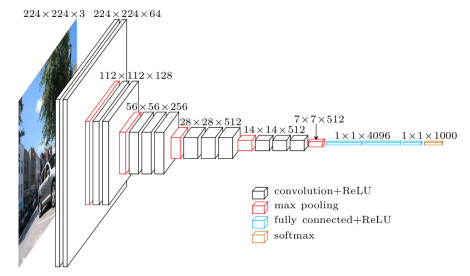

In [2]:
from IPython.display import Image
print("VGG16:")
Image('./images/imagenet_vgg16.png')

## Use keras' VGG16 (pictured above) pretrained on ImageNet to get bottleneck features

In [5]:
import os
import pandas as pd
import numpy as np
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout, Flatten, Dense
from tensorflow.python.keras import applications

# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'data/images/train'
validation_data_dir = 'data/images/validation'
nb_train_samples = 200
nb_validation_samples = 40
epochs = 50
batch_size = 1


def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save(open(os.path.join(train_data_dir,'bottleneck_features_train.npy'), 'wb'),
            bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save(open(os.path.join(validation_data_dir,'bottleneck_features_validation.npy'), 'wb'),
            bottleneck_features_validation)


Save features to disk so we don't need to compute them again

In [17]:
save_bottlebeck_features()

Found 200 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


## Load the bottleneck features and format them for input into sklearn ML algorithms

In [18]:
train_np = np.load(open(os.path.join(train_data_dir,'bottleneck_features_train.npy'), 'rb'))
val_np = np.load(open(os.path.join(validation_data_dir,'bottleneck_features_validation.npy'), 'rb'))
df_train = pd.DataFrame(data=train_np.flatten().reshape(200, 512*4*4))
df_train['label'] = 0
df_train['label'].iloc[100:] = 1
X_train = df_train.iloc[:, :8192].values
y_train = df_train.iloc[:, 8192:].values.ravel()

df_val = pd.DataFrame(data=val_np.flatten().reshape(40, 512*4*4))
df_val['label'] = 0
df_val['label'].iloc[20:] = 1
X_val = df_val.iloc[:, :8192].values
y_val = df_val.iloc[:, 8192:].values.ravel()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [19]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc_model = rfc.fit(X_train, y_train)

In [20]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X) # predict y values from input X
    print("Accuracy: {}%".format(model.score(X, y)*100.0))
evaluate_model(rfc_model, X_val, y_val)

Accuracy: 70.0%


## Let's try with a new image!


In [21]:
import urllib
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

label_map = {0: 'cat', 1: 'dog'}
def preview_image(url):
    urllib.request.urlretrieve(url, './image.jpg')
    img = cv2.imread('./image.jpg')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [22]:
model = applications.VGG16(include_top=False, weights='imagenet')

def get_bottleneck_features(image):
    datagen = ImageDataGenerator(rescale=1. / 255)
    image_rsz = cv2.resize(image, (img_width, img_height))
    image_rsz = image_rsz[:,:,:]
    features = model.predict(np.array([image_rsz]))
    return features.reshape(1, 512*4*4)

def predict_cat_dog(url: str):
    preview_image(url)
    urllib.request.urlretrieve(url, './image.jpg')
    img = cv2.imread('./image.jpg')
    features = get_bottleneck_features(img)
    pred = rfc_model.predict(features).squeeze()
    print(f'prediction is {label_map[int(pred)].upper()}')

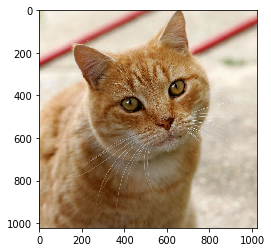

prediction is CAT


In [23]:
predict_cat_dog('https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1024px-Cat03.jpg')

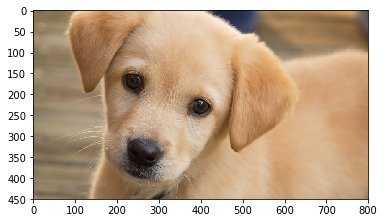

prediction is DOG


In [24]:
predict_cat_dog('https://i.kinja-img.com/gawker-media/image/upload/s--kx3d-Wgg--/c_scale,fl_progressive,q_80,w_800/ol9ceoqxidudap8owlwn.jpg')

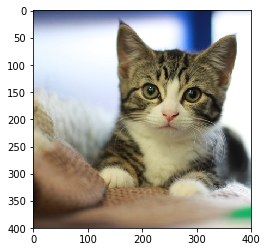

prediction is CAT


In [25]:
predict_cat_dog('https://d1wn0q81ehzw6k.cloudfront.net/additional/thul/media/0eaa14d11e8930f5?w=400&h=400')

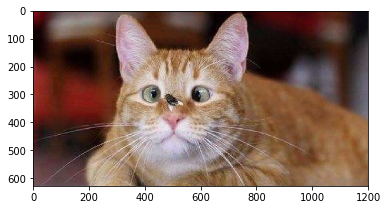

prediction is CAT


In [26]:
predict_cat_dog('https://thechive.files.wordpress.com/2018/02/lead53.jpg?quality=85&strip=info')

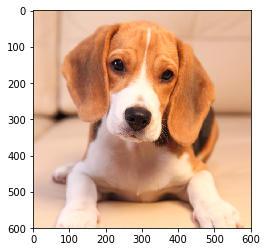

prediction is CAT


In [27]:
predict_cat_dog('https://www.what-dog.net/Images/faces2/scroll001.jpg')

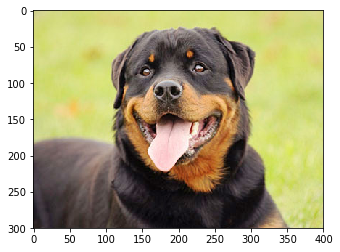

prediction is DOG


In [28]:
predict_cat_dog('http://www.dogbreedslist.info/uploads/allimg/dog-pictures/Rottweiler-1.jpg')